In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras import backend as K
import keras
import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import *
from keras.applications import MobileNetV2,Xception,ResNet50,VGG16
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.models import model_from_json
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import PIL
from matplotlib.pyplot import imshow
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image 

In [3]:
home_path = "/content/drive/Shareddrives/Data2040FinalProj/streetview/"
train_xml_path = home_path + 'train.xml'

In [4]:
root = ET.parse(train_xml_path).getroot()
imgs_path = []
groundtruth_boxes = []
for i in root.iterfind('image'):
    imgs_path.append([home_path + j.text for j in i.iterfind('imageName')])
    groundtruth_boxes.append([list(r.attrib.values()) + list([t.text for t in r.iterfind('tag')]) for rs in i.iterfind('taggedRectangles') for r in rs.iterfind('taggedRectangle')])
imgs_path = np.array(imgs_path)
groundtruth_boxes = np.array(groundtruth_boxes, dtype='object')

In [5]:
img_w = 512
img_h = 512
channels = 3
classes = 1
info = 5
grid_w = 16
grid_h = 16

In [6]:
X_final = []
Y_final = []
for z in range(len(imgs_path)):
    
    new_file = imgs_path[z]
    #print(new_file)
    x = cv2.imread(imgs_path[z][0])
    x_sl = 512/x.shape[1]
    y_sl = 512/x.shape[0]
    
    img = cv2.resize(x,(512,512))
       
    X_final.append(img)
    
    Y = np.zeros((grid_h,grid_w,1,5))
    
    data = groundtruth_boxes[z]
    
    for file_data in data:
        temp_list = []
        strr = file_data[4]
        bb = file_data[:4]
        
        # change for dataset center
        xmin = int(bb[2]) * x_sl
        xmax = (int(bb[2]) + int(bb[1])) * x_sl
        ymin = int(bb[3])* y_sl
        ymax = (int(bb[3]) + int(bb[0])) * y_sl
        # xmin = int(bb[0])*x_sl
        # xmax = int(bb[2])*x_sl
        # ymin = int(bb[1])*y_sl
        # ymax = int(bb[3])*y_sl
        
        # te = cv2.rectangle(img,(int(xmin),int(ymin)),(int(xmax),int(ymax)) , color = (0,255,0))
        
        w = (xmax - xmin)/img_w
        h = (ymax - ymin)/img_h
        
        x = ((xmax + xmin)/2)/img_w
        y = ((ymax + ymin)/2)/img_h
        x = x * grid_w
        y = y * grid_h
        
        Y[int(y),int(x),0,0] = 1
        Y[int(y),int(x),0,1] = x - int(x)
        Y[int(y),int(x),0,2] = y - int(y)
        Y[int(y),int(x),0,3] = w
        Y[int(y),int(x),0,4] = h
        
    # plt.imshow(te)
    # plt.show()
    Y_final.append(Y)
    




X = np.array(X_final)
X_final = []
Y = np.array(Y_final)
Y_final = []

X = (X - 127.5)/127.5


In [7]:
imgs_path[0][0]

'/content/drive/Shareddrives/Data2040FinalProj/streetview/img/14_03.jpg'

In [8]:
indices = np.arange(0,len(X))
train_idx, val_idx = train_test_split(indices, test_size=0.25, train_size=None,shuffle = True)
X_train = X[train_idx]
Y_train = Y[train_idx]
X_val = X[val_idx]
Y_val = Y[val_idx]
path_train = imgs_path[train_idx]
path_valid = imgs_path[val_idx]
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((75, 512, 512, 3), (25, 512, 512, 3), (75, 16, 16, 1, 5), (25, 16, 16, 1, 5))

In [9]:
# X_train , X_val , Y_train , Y_val  = train_test_split(X,Y,train_size = 0.75 , shuffle = True)
# X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

In [10]:
def decode_to_boxes(output , ht , wd):
    #output : (x,x,1,5)
    #x,y,h,w

    img_ht = ht
    img_wd = wd
    threshold = 0.5
    grid_h,grid_w = output.shape[:2]
    final_boxes = []
    scores = []

    for i in range(grid_h):
        for j in range(grid_w):
            if output[i,j,0,0] > threshold:

                temp = output[i,j,0,1:5]
                
                x_unit = ((j + (temp[0]))/grid_w)*img_wd
                y_unit = ((i + (temp[1]))/grid_h)*img_ht
                width = temp[2]*img_wd*1.3
                height = temp[3]*img_ht*1.3
                
                final_boxes.append([x_unit - width/2,y_unit - height/2 ,x_unit + width/2,y_unit + height/2])
                scores.append(output[i,j,0,0])
    
    return final_boxes,scores



def iou(box1,box2):

    x1 = max(box1[0],box2[0])
    x2 = min(box1[2],box2[2])
    y1 = max(box1[1] ,box2[1])
    y2 = min(box1[3],box2[3])
    
    inter = (x2 - x1)*(y2 - y1)
    
    area1 = (box1[2] - box1[0])*(box1[3] - box1[1])
    area2 = (box2[2] - box2[0])*(box2[3] - box2[1])
    fin_area = area1 + area2 - inter
        
    iou = inter/fin_area
    
    return iou



def non_max(boxes , scores , iou_num):

    scores_sort = scores.argsort().tolist()
    keep = []
    
    while(len(scores_sort)):
        
        index = scores_sort.pop()
        keep.append(index)
        
        if(len(scores_sort) == 0):
            break
    
        iou_res = []
    
        for i in scores_sort:
            iou_res.append(iou(boxes[index] , boxes[i]))
        
        iou_res = np.array(iou_res)
        filtered_indexes = set((iou_res > iou_num).nonzero()[0])

        scores_sort = [v for (i,v) in enumerate(scores_sort) if i not in filtered_indexes]
    
    final = []
    
    for i in keep:
        final.append(boxes[i])
    
    return final


def decode(output , ht , wd , iou):
    
    
    boxes , scores = decode_to_boxes(output ,ht ,wd)
    
    
    boxes = non_max(boxes,np.array(scores) , iou)
    
    
    return boxes

In [11]:
def load_model(strr):        
    json_file = open(strr, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model

In [12]:
model_det = load_model("/content/drive/Shareddrives/Data2040FinalProj/SSD_model/model.json")
model_det.load_weights("/content/drive/Shareddrives/Data2040FinalProj/SSD_model/model_ref.h5")

In [41]:
# i is the position of image in the dataset
def crop_bounding_boxes(model,i,dataset,img_w,img_h,output_w=None,output_h=None):
  crop_images = []
  
  # get the input
  inp = dataset[i:i+1]

  # get bounding box
  ans = model.predict(inp)
  boxes = decode(ans[0] , img_w , img_h , 0.5)

  # get original image
  img = ((inp + 1)/2)
  img = img[0]
  # plt.imshow(img)
  # plt.show()

  # get corresponding grey scale image
  if dataset == X_train:
    image_path = path_train[i][0]
  else:
    image_path = path_valid[i][0]

  image_file = Image.open(image_path) # open colour image
  #image_file = image_file.convert('L') # convert image to black and white
  image_file = image_file.resize((512,512))
  plt.imshow(image_file)
  plt.show()


  # crop the bounding boxes
  for j in range(len(boxes)):
    # crop_img = img[int(boxes[j][1]):int(boxes[j][3]), int(boxes[j][0]):int(boxes[j][2])]
    # plt.imshow(crop_img)
    # plt.show()
    # print(boxes[j])
    crop_img = image_file.crop((int(boxes[j][0]), int(boxes[j][1]), int(boxes[j][2]), int(boxes[j][3])))
    plt.imshow(crop_img, cmap = 'gray')
    plt.show()

    # resize if necessary
    if output_w != None and output_h != None:
      crop_img = cv2.resize(crop_img,(output_w,output_h))
    
    # display cropped bounding boxes
    # plt.imshow(crop_img)
    # plt.show()

    # store images in the list
    crop_images.append(crop_img)

  return crop_images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


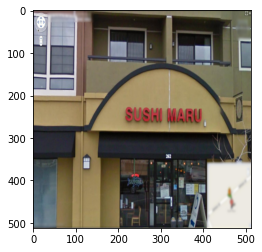

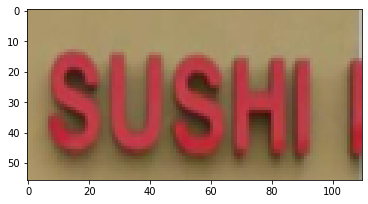

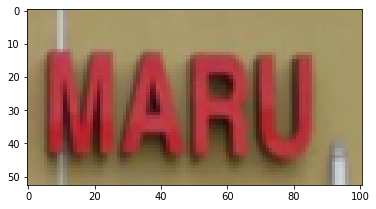

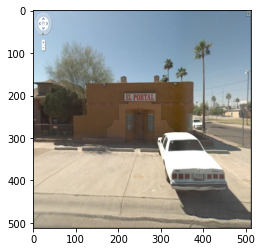

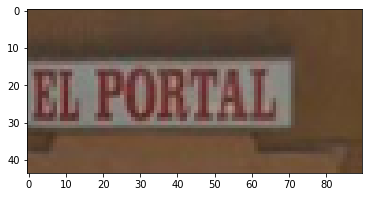

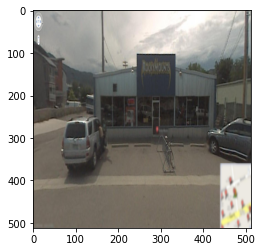

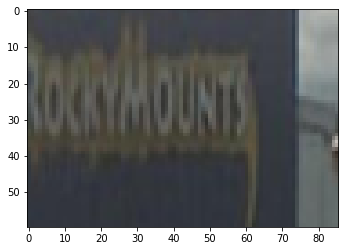

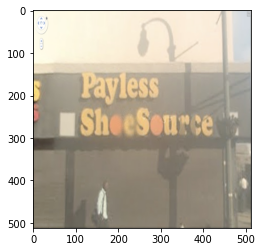

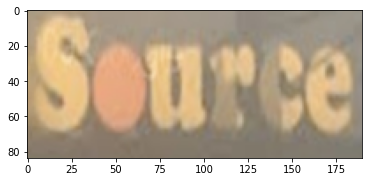

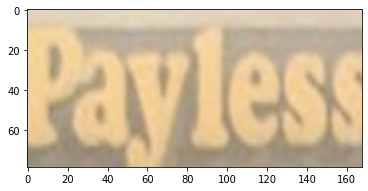

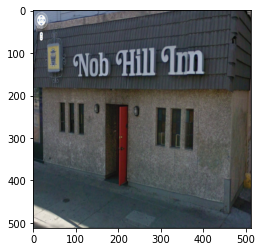

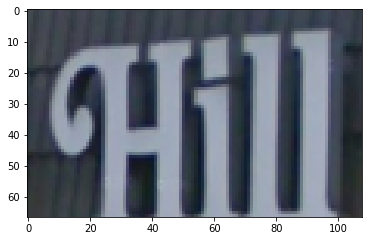

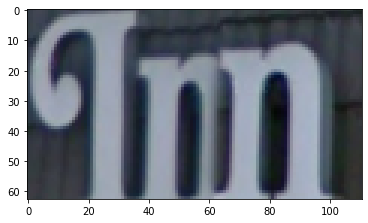

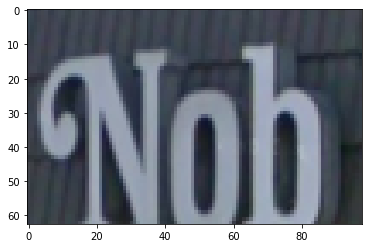

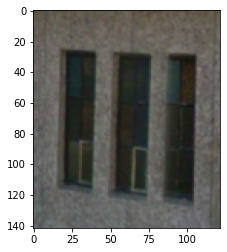

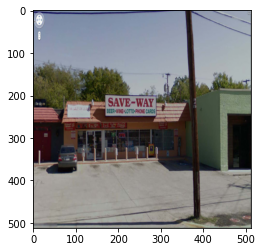

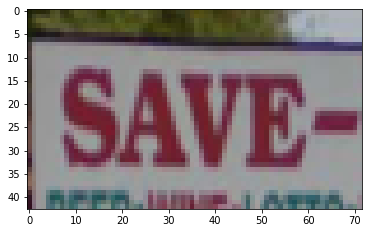

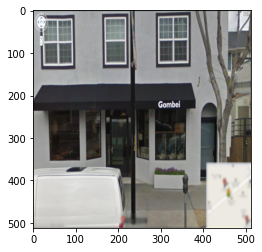

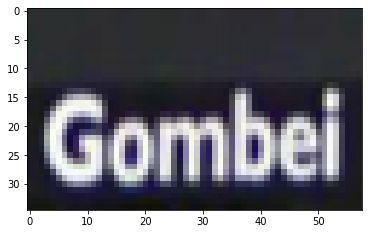

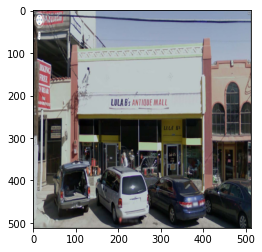

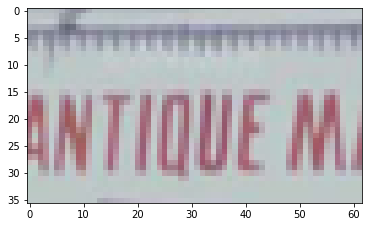

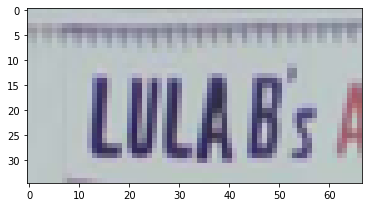

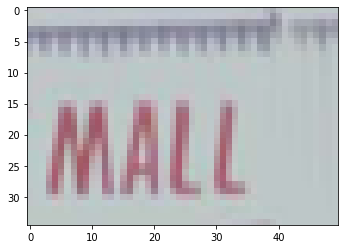

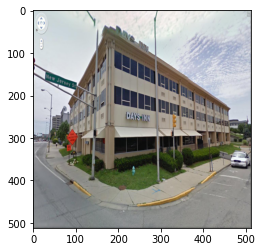

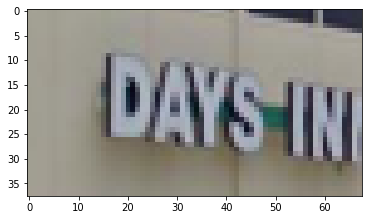

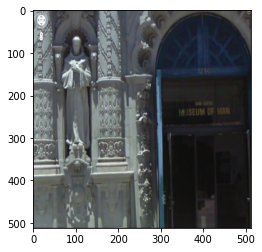

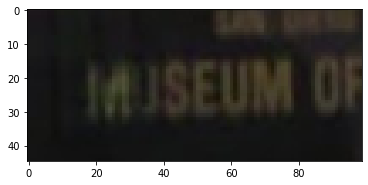

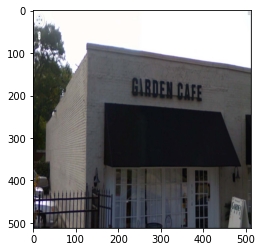

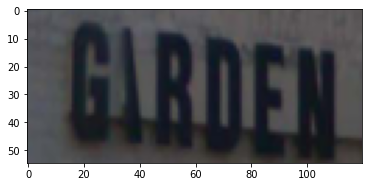

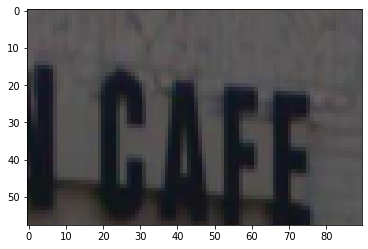

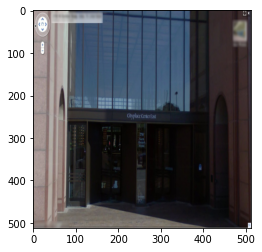

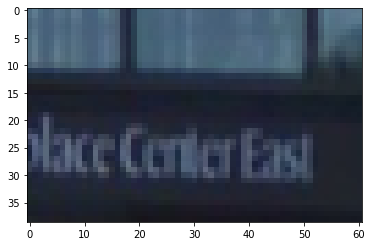

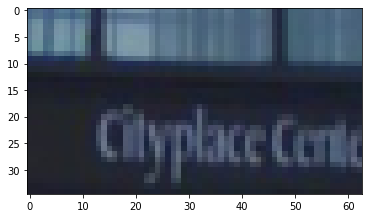

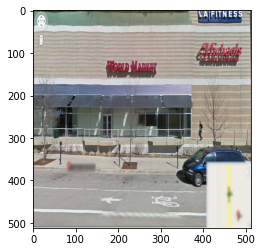

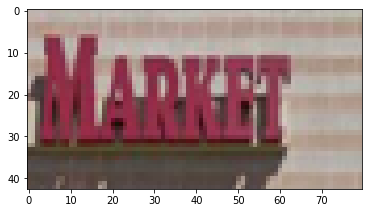

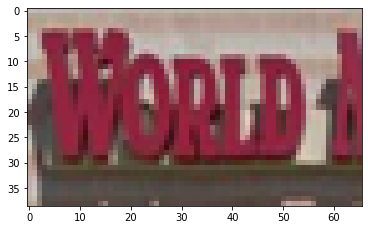

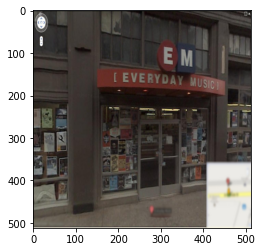

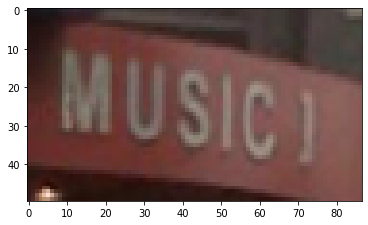

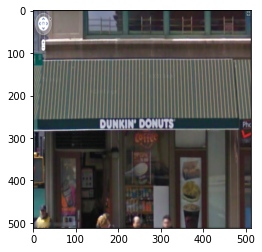

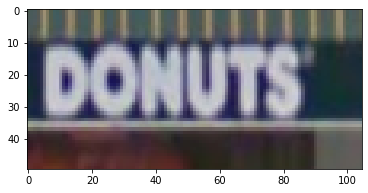

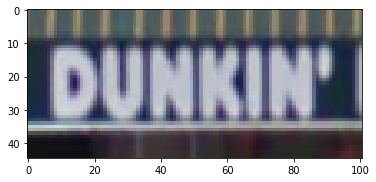

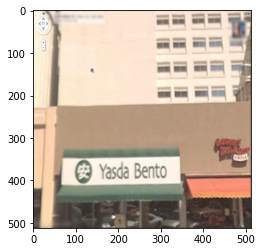

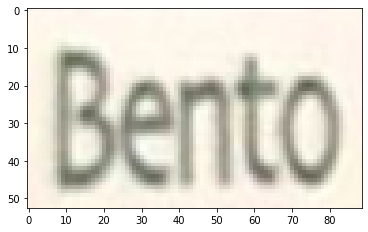

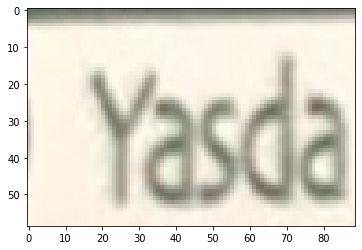

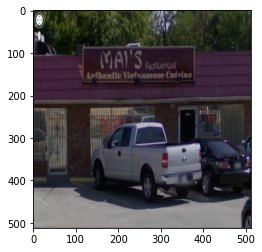

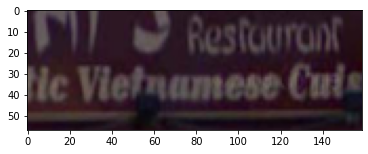

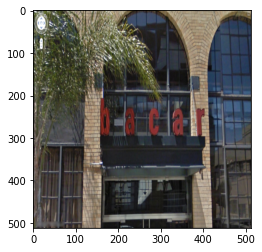

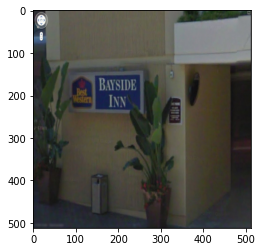

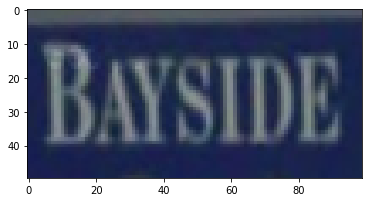

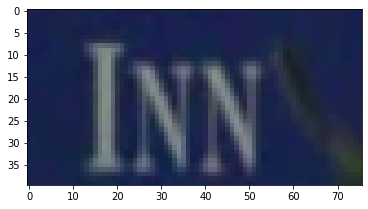

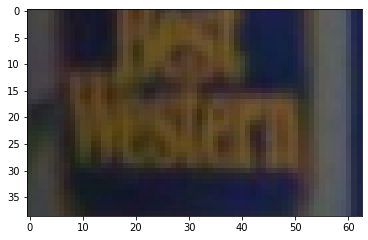

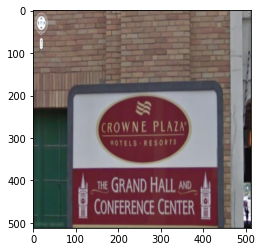

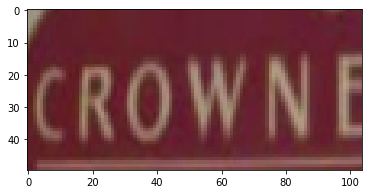

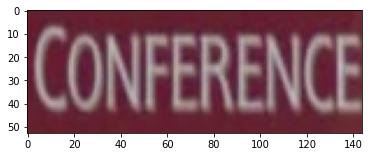

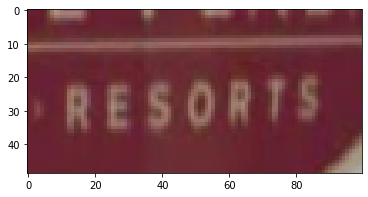

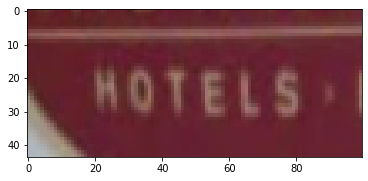

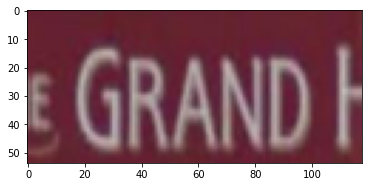

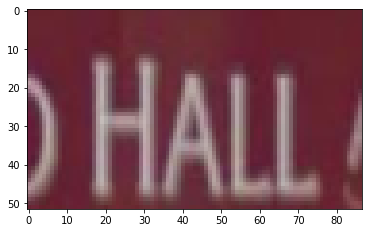

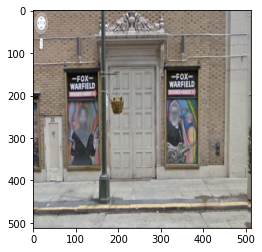

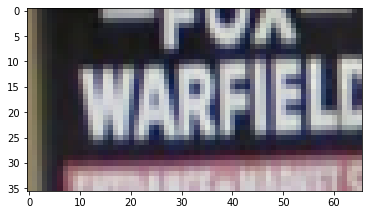

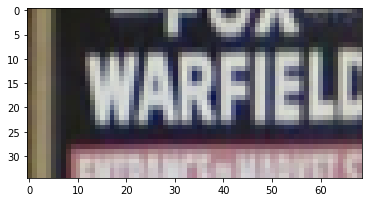

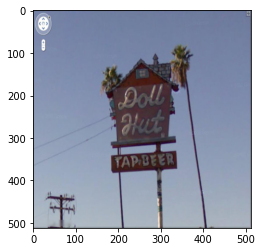

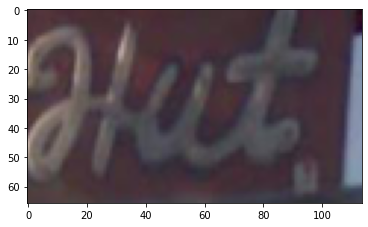

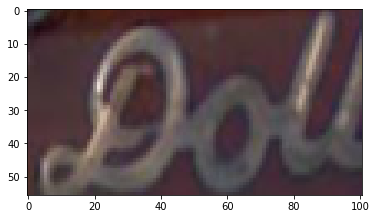

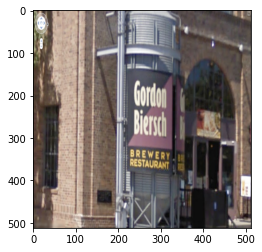

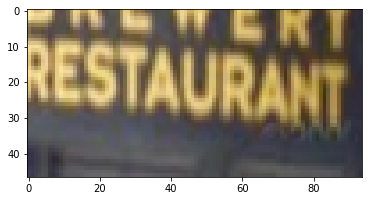

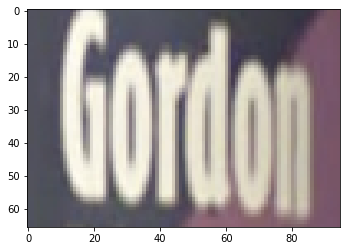

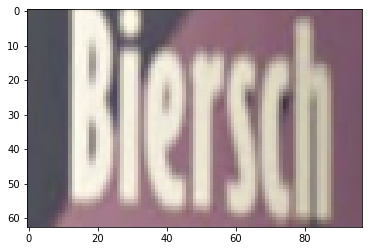

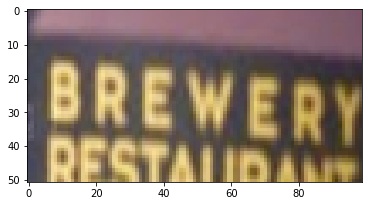

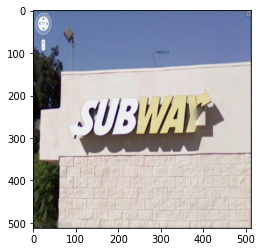

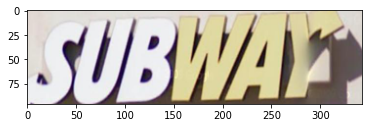

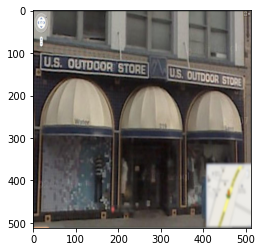

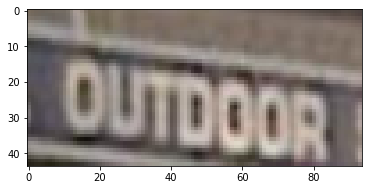

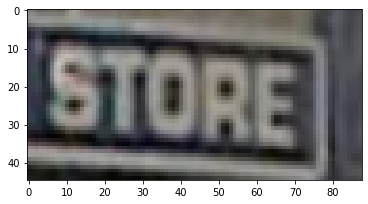

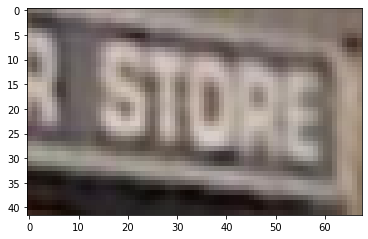

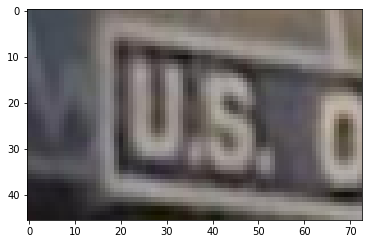

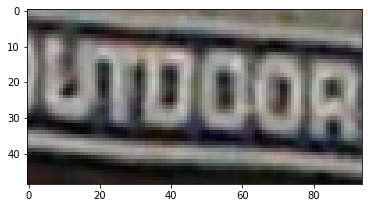

In [42]:
crops = []
for i in range(len(X_val)):
  images = crop_bounding_boxes(model_det,i,X_val,512,512)
  for image in images:
    crops.append(image)

In [16]:
len(crops)

52

In [17]:
# for crop in crops:
#   plt.imshow(crop)
#   plt.show()
#   crop.save("/content/drive/Shareddrives/Data2040FinalProj/streetview/img/test.png","PNG")
#   image = cv2.imread("/content/drive/Shareddrives/Data2040FinalProj/streetview/img/test.png")
#   print(text_recog([image]))


#text recognition

In [21]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io


import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.models import load_model

In [32]:
# design a function return final text prediction:

def text_recog(image_list):

      valid_size= len(image_list)

      # prepare image processing
      def preprocess(img):
          img = cv2.resize(img, (128, 32))
          (h, w) = img.shape
          final_img = np.ones([32, 128])*255 # blank white image
          
          final_img[:h, :w] = img

          return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

      # 1.append prediction dataset
      pred_x = []

      for i in range(len(image_list)):
          img = image_list[i]
          img = img[:,:,0]
          image = preprocess(img)
          image = image/255.
          pred_x.append(image)
      
      pred_x = np.array(pred_x).reshape(-1, 128, 32, 1)
      
      # 2.decoding function
      alphabets = u"0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
      max_str_len = 24 # max length of input labels
      num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
      num_of_timestamps = 32 # max length of predicted labels


      def label_to_num(label):
          label_num = []
          for ch in label:
              label_num.append(alphabets.find(ch))
              
          return np.array(label_num)

      def num_to_label(num):
          ret = ""
          for ch in num:
              if ch == -1:  # CTC Blank
                  break
              else:
                  ret+=alphabets[ch]
          return ret


      # 3. predict and return
      model = load_model("/content/drive/Shareddrives/Data2040FinalProj/x6/dpu4.h5")
      preds = model.predict(pred_x)
      decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

      prediction = []
      for i in range(valid_size):
          prediction.append(num_to_label(decoded[i]))

      return prediction
     

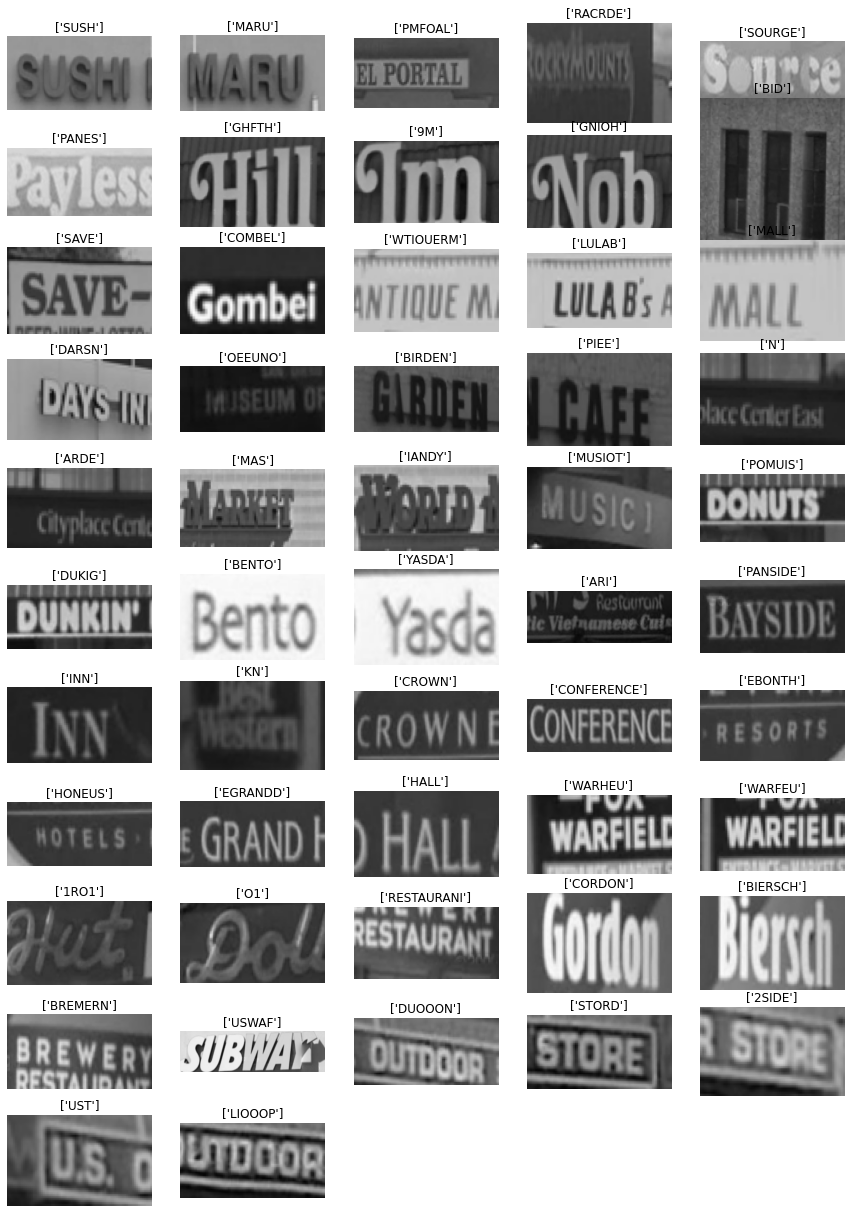

In [33]:
plt.figure(figsize=(15, 30))

i = 0
for crop in crops:
  ax = plt.subplot(11, 5, i+1)
  crop.save("/content/drive/Shareddrives/Data2040FinalProj/streetview/img/test.png","PNG")
  image = cv2.imread("/content/drive/Shareddrives/Data2040FinalProj/streetview/img/test.png")
  plt.imshow(image, cmap = 'gray')
  plt.title(text_recog([image]), fontsize=12)
  plt.axis('off')
  i += 1

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [31]:
image = cv2.imread("/content/drive/Shareddrives/Data2040FinalProj/streetview/img/test.png")
text_recog([image])
#text_recog([images[1]])

['MOOOR']